# Setup

**Last lecture**: we used Plotly to create choropleth and symbol maps using a dataset of the worlds countries. The simple approach only worked because <u>Plotly has built-in support for country shapes if 3-digit iso codes</u> are provided.

**This lecture**: we cover the more difficult scenario in which we <u>supply the geo data ourselves</u>. For processing of the geo data, we use the package **GeoPandas**. The visualizations are carried out by **Matplotlib** because it is more powerful in the context of GeoData. For a corresponding Plotly example see the [documentation](https://plotly.com/python/choropleth-maps/#using-geopandas-data-frames).

## Package Installation

- The package **GeoPandas** has several optional dependencies (e.g. matplotlib, folium, geopy, ...). I recommend you install also all these optional dependencies via `geopandas[all]`. Ocasionally, the installation of GeoPandas comes with difficulties, because the package has <u>system-level dependencies</u>. If you run into problems, consult the [information on the GeoPandas Website](https://geopandas.org/en/stable/getting_started/install.html)
- The package **osmnx** will be used to download geo data using APIs of OpenStreetMap (Nominatim, Overpass). 

In [2]:
# !pip install geopandas[all] osmnx

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Normal Data Frame

- We work with the same data set as last lecture (World Development Indicators)
- This time, we don't use Plotly's built-in vector data, but add external vector data about countries

In [4]:
df = pd.read_csv("wdi.csv")
df = df[df.year==2020].reset_index(drop=True)
df.head(3)

iso3      country  capital continent                      region  year  \
0  AFG  Afghanistan    Kabul      Asia                  South Asia  2020   
1  ALB      Albania   Tirane    Europe       Europe & Central Asia  2020   
2  DZA      Algeria  Algiers    Africa  Middle East & North Africa  2020   

   population           gdp    gdp_capita  life_expectancy  fertility  \
0  38972230.0  8.100749e+10   2078.595086           62.575      4.750   
1   2837849.0  3.991162e+10  14064.038615           76.989      1.400   
2  43451666.0  4.976183e+11  11452.226624           74.453      2.942   

   maternal_death_risk  infant_mortality_1000  greenhousegas_capita  
0             3.130210                   44.8           31119.04539  
1             0.011492                    8.4            8304.29494  
2             0.241703                   19.6          266702.67950

# 2. Geo Data

## 2.1 Reading Geo Data

- We need to identify suitable geo data that contains (1) **shapes of countries**, and (2) a **suitable identifier** that allows us to merge it with the data set above (e.g. iso3 code, or country name).
- There are many online sources for geo data (see also lecture slides). GeoPandas can handle all typical geo data types, including **shapefile**, **geojson**, **geopackage**, and others. 
- We use data from https://www.naturalearthdata.com: the website provides cultural (e.g. country borders), physical (e.g. rivers, lakes), and raster (e.g. ocean depth) data in different levels of detail. An overview of the available data can be found [here](https://www.naturalearthdata.com/features/). Our dataset is called [Admin 0 - Countries](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/50m-admin-0-countries/).

In [5]:
countries = gpd.read_file("ne_50m_admin_0_countries.zip")
countries.columns = countries.columns.str.lower()
countries = countries[["geometry", "iso_a3_eh"]]
countries.rename(columns={"iso_a3_eh":"iso3"}, inplace=True)
countries.head(3)

geometry iso3
0  POLYGON ((31.28789 -22.40205, 31.19727 -22.344...  ZWE
1  POLYGON ((30.39609 -15.64307, 30.25068 -15.643...  ZMB
2  MULTIPOLYGON (((53.08564 16.64839, 52.58145 16...  YEM

## 2.2 Plotting Geo Data

This GeoDataFrame can be visualized using the `plot` method.

<Axes: >

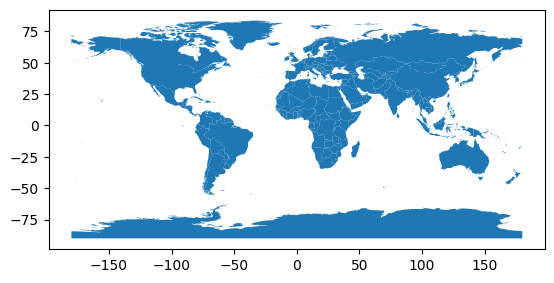

In [6]:
countries.plot()

The GeoPandasDataFrame is an enhanced version of a DataFrame. It inherits most of the methods that we know from Pandas (aggregating, filtering, merging, ...), but has additional methods and attributes for geo data operations.

In [7]:
type(countries)   # Data Type

geopandas.geodataframe.GeoDataFrame

In [8]:
countries[countries.iso3 == "DEU"].explore()

## 2.3 Projections

In [9]:
countries.crs     # Coordinate Reference System (CRS)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

- The current CRS is called **EPSG:4326**. It is based on a model of the earth called **WGS 84**, which is used by the Global Positioning System (GPS). It is important for navigation systems, but can be misleading for thematic maps.
- We can change the coordinate reference system using the `to_crs()` method.
- For thematic maps of the world, we prefer equal-area projections: e.g. Mollweide (ESRI:54009), Equal Earth (EPSG:8857). Projected CRS always use a metric system, rather than degrees longitude and latitude.

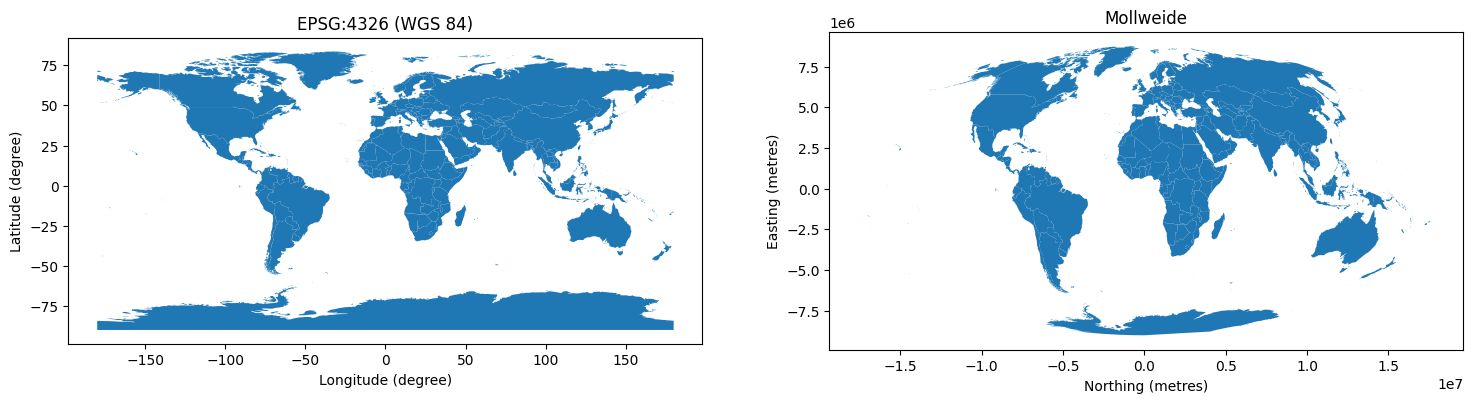

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
countries.plot(ax=ax[0])
ax[0].set_title('EPSG:4326 (WGS 84)')
ax[0].set_ylabel('Latitude (degree)')
ax[0].set_xlabel('Longitude (degree)')

countries_mollweide = countries.to_crs("ESRI:54009")
countries_mollweide.plot(ax=ax[1])
ax[1].set_title('Mollweide')
ax[1].set_xlabel('Northing (metres)')
ax[1].set_ylabel('Easting (metres)');


In [31]:
countries_mollweide.crs

<Projected CRS: ESRI:54009>
Name: World_Mollweide
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Coordinate Operation:
- name: World_Mollweide
- method: Mollweide
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

- We can easily compute the `area` of countries
- Important: we must have an <u>equal area projection in meters</u> for this!

In [11]:
countries_mollweide['area'] = countries_mollweide.area / 1e6    # m^2 --> km^2
countries_mollweide[countries_mollweide.iso3=="DEU"]

geometry iso3           area
156  MULTIPOLYGON (((747297.278 5611794.24, 732984....  DEU  356962.181394

# 3 Merging the data

Hints: 

- Take the GeoDataFrame as your `left` data -> This makes sure that the resulting data is also a GeoDataFrame (not a simple DataFrame)
- Carry out a left join (`how="left"`): Otherwise you may run the risk of having strange holes in the map

<Axes: >

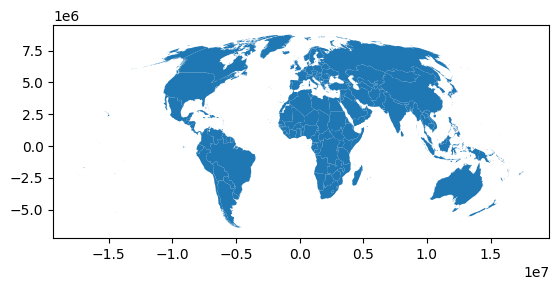

In [ ]:
gdf_test = pd.merge(left=countries_mollweide, right=df, on='iso3', how='right')
gdf_test.plot() # eg. antarctica is missing

<Axes: >

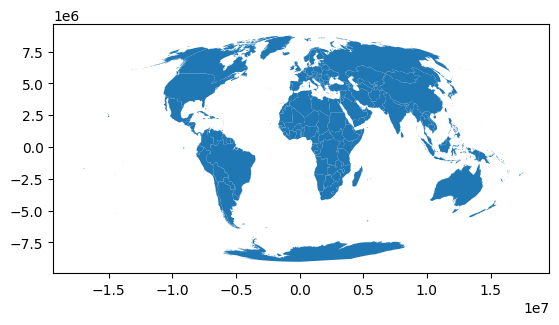

In [ ]:
gdf = pd.merge(left=countries_mollweide, right=df, on='iso3', how='left')
gdf.plot()

# 4. Visualization

Starting from a GeoPandas DataFrame, we have two convenient visualization methods:

1. `plot()`: wrapper around the **matplotlib** library producing a <u>static plot</u> ([documentation](https://geopandas.org/en/stable/docs/user_guide/mapping.html)).	
2. `explore()`: wrapper around the **folium** library producing an <u>interactive plot</u> ([documentation](https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html))

## 4.1 Static Matplotlib Map

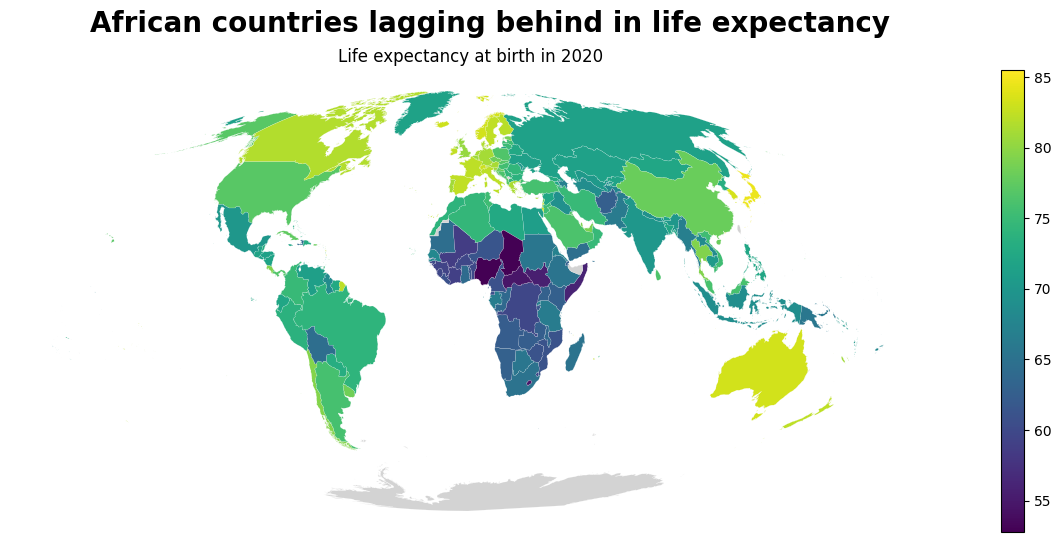

In [13]:
fig, ax = plt.subplots(figsize=(18, 6))
gdf.plot(
    column="life_expectancy",                # Data column for color encoding
    legend=True,                             # Legend toggle   
    cmap="viridis",                          # Color palette    
    edgecolor="white",                       # Color of country boundaries
    linewidth=0.1,                           # Width of the country boundaries
    missing_kwds={"color": "lightgrey"},     # Color for counties with missing values
    ax = ax)

ax.axis("off");                             # Hide axis
ax.set_title("Life expectancy at birth in 2020")
fig.suptitle("African countries lagging behind in life expectancy", fontsize=20, fontweight="bold")

#plt.rcParams['svg.fonttype'] = 'none'        # Recommended if you plan to optimize your map using vector graphics programms
fig.savefig("life_expectancy.svg")

## 4.2 Interactive Folium Map

- The `explore()` method is a wrapper around the `folium` library, which is in turn a Python wrapper for the JavaScript library `Leaflet.js`. 
- The functionalities are comparable to Plotly's interactive maps
- Note the problems that Leaflet has for polygons at the far west and east (longitude=+/-180°)

In [14]:
import folium
m = folium.Map(
    zoom_start=2,                         # Initial zoom level (0-18)
    height=600,                           # Height of the map
    width=800,                            # Width of the map
)

gdf.explore(
    m=m,                                   # Folium Map Object
    column="life_expectancy",              # Data column for color encoding
    tooltip=["life_expectancy","country"], # Columns to show in tooltip
    cmap="viridis"                         # Color palette
) 



# 5. Geo Data Manipulation

## 5.1 Normal Pandas-type operations

As with the basic Pandas DataFrames we can filter the GeoPandas DataFrames based on conditions, e.g. to only put certain countries on the map.

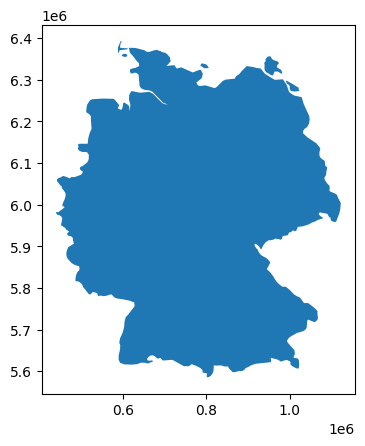

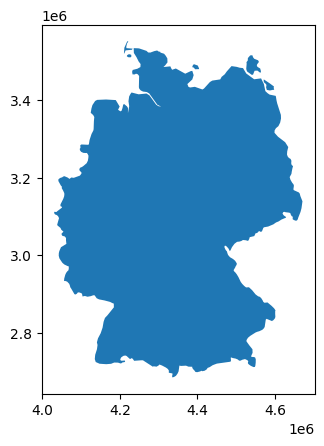

In [37]:
gdf[gdf.country=="Germany"].plot();
gdf[gdf.country=="Germany"].to_crs('EPSG:3035').plot();

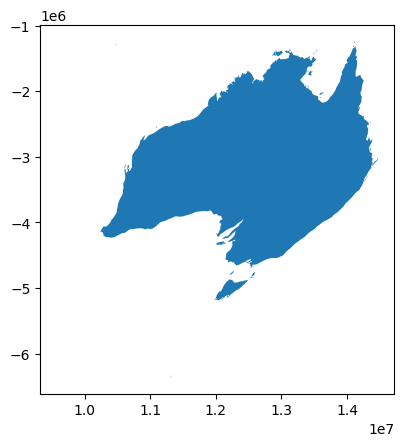

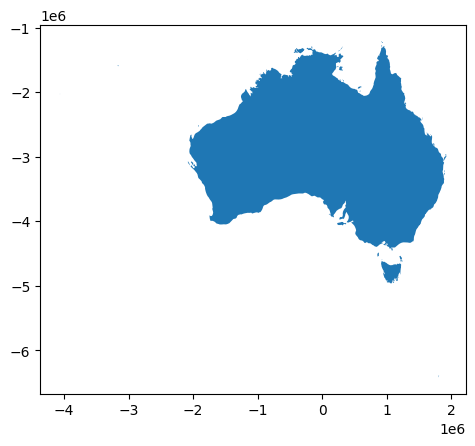

In [36]:
gdf[gdf.country=="Australia"].plot();
gdf[gdf.country=="Australia"].to_crs('EPSG:3112').plot();

## 5.2 Spatial Aggregation

If we use **Pandas aggregation functions** sum, mean, ... we <u>loose all spatial information</u>. 


In [16]:
gdf.groupby('continent').life_expectancy.mean()

continent
Africa      63.572531
Americas    74.298825
Asia        74.207140
Europe      78.726547
Oceania     73.342280
Name: life_expectancy, dtype: float64

Instead, we can use `dissolve`: it applies the aggregation function and dissolves the geometries into a single one.

In [17]:
continents = gdf.dissolve(by='continent', aggfunc={'life_expectancy': 'mean'})
continents

geometry  life_expectancy
continent                                                                    
Africa     MULTIPOLYGON (((-302505.919 636508.768, -30631...        63.572531
Americas   MULTIPOLYGON (((-10204812.448 -3304496.106, -1...        74.298825
Asia       MULTIPOLYGON (((5347036.264 1523781.796, 53069...        74.207140
Europe     MULTIPOLYGON (((-5426661.894 355403.728, -5424...        78.726547
Oceania    MULTIPOLYGON (((-14336996.684 -5267463.542, -1...        73.342280

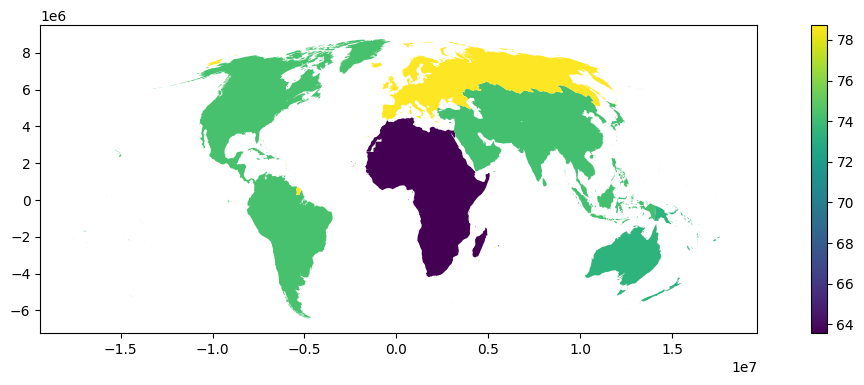

In [18]:
continents.plot(column='life_expectancy', legend=True, figsize=(14,4));

## 5.3 Spatial joins

- In section 1 of this notebook, we carried out a **normal merge/join**, using a Pandas DataFrame (World Development Indicators) with a GeoPandas DataFrame (geometries of countries) <u>based on a common attribute</u> (iso3).
- In this section, we carry out a **spatial join**, <u>based on the spatial relationship between the geometries</u> of two data sets, see [Geopandas documentation](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html)

<Axes: >

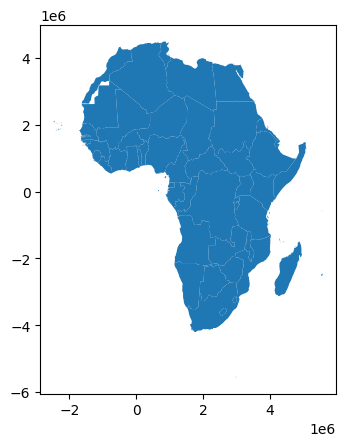

In [19]:
africa = gdf[gdf.continent=="Africa"]
africa.plot()

<Axes: >

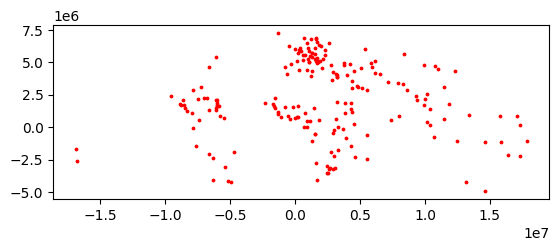

In [20]:
cities = gpd.read_file("ne_50m_populated_places_simple.zip")
cities.to_crs('ESRI:54009', inplace=True)
cities.columns = cities.columns.str.lower()
capitals = cities[cities.featurecla.isin(['Admin-0 capital'])]
capitals.plot(color="red", markersize=3)

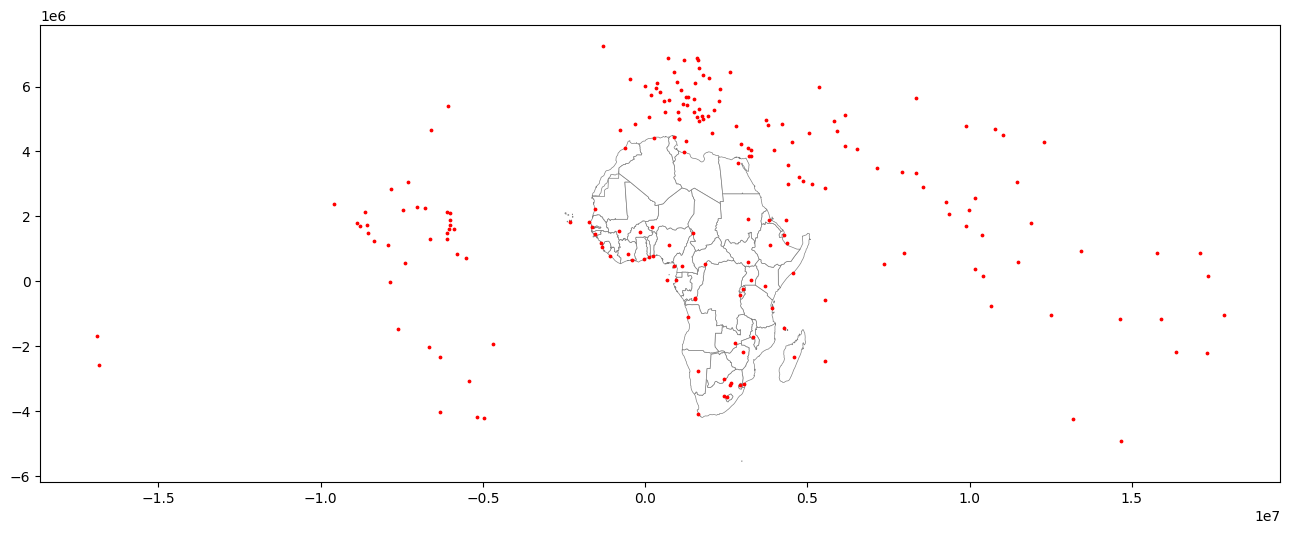

In [21]:
# We can now plot the two GeoDataFrames together in a layered way
fig, ax = plt.subplots(figsize=(16, 7))
africa.plot(ax=ax, color='white', edgecolor='grey', linewidth=0.5)
capitals.plot(ax=ax, color='red', markersize=3);

**Challenge**: we want to identify all African capital cities, just based on their geographical locations

- We perform a spatial join between the african countries and the capitals
- We use the `within` predicate to find all the capitals that are located within the boundaries of an african countries

In [22]:
africa_capitals = capitals.sjoin(africa[['geometry', 'iso3']], how='inner', predicate='within')

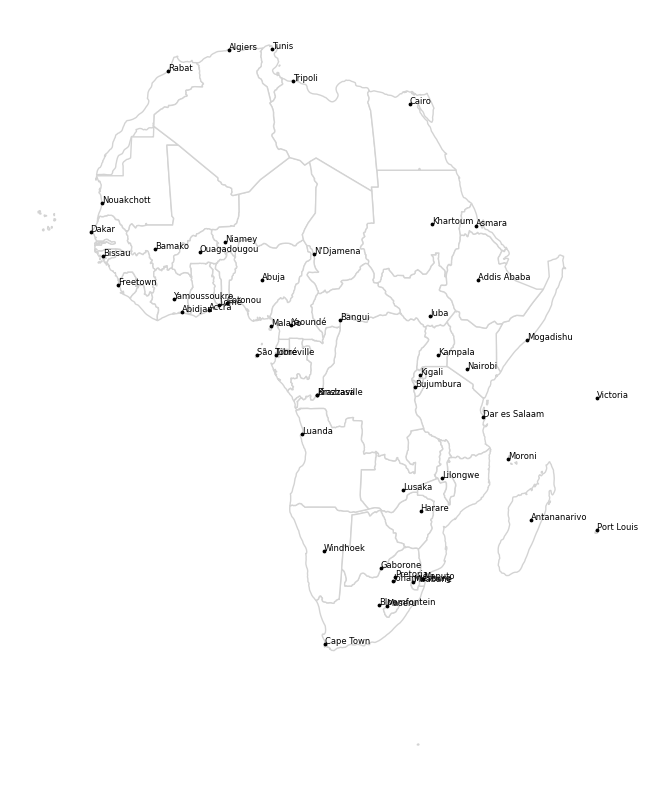

In [23]:
fig, ax = plt.subplots(figsize=(12, 10))
africa.plot(ax=ax, color='white', edgecolor='lightgrey')
africa_capitals.plot(ax=ax, color="black", markersize=3);
ax.set_axis_off()

for row in africa_capitals.itertuples():
    ax.text(
        x=row.geometry.x,      # x-coordinate of the Point
        y=row.geometry.y,      # y-coordinate of the Point
        s=row.name,            # attribute 'name'
        fontsize=6, color="black"
    )

# 6. Powerful geo data tools

## 6.1 Geocoding

- **Geocoding**: <u>convert names or addresses into geographic coordinates</u> (latitude and longitude)
- **Example**: Where is "Fachhochschule Kiel" located?

In [24]:
from pprint import pprint
from geopy.geocoders import Nominatim

# We use the free Nominatim API (OpenStreetMap), but their are many (paid) alternatives (Goolge, Bing...)
geolocator = Nominatim(user_agent="data-science-kiel")

In [25]:
location = geolocator.geocode("University of Applied Sciences Kiel", limit=3, exactly_one=False, language="de", country_codes=["DE", "US"])
pprint(location[0].raw)

{'addresstype': 'amenity',
 'boundingbox': ['54.3293190', '54.3356426', '10.1777790', '10.1825515'],
 'class': 'amenity',
 'display_name': 'HAW Kiel, Groß Ebbenkamp, Neumühlen-Dietrichsdorf, Kiel, '
                 'Schleswig-Holstein, 24149, Deutschland',
 'importance': 0.3512709993284504,
 'lat': '54.3324179',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. '
            'http://osm.org/copyright',
 'lon': '10.1798014',
 'name': 'HAW Kiel',
 'osm_id': 25964094,
 'osm_type': 'way',
 'place_id': 138625659,
 'place_rank': 30,
 'type': 'university'}


- **Revers Geoocoding**: <u>convert geographic coordinates into a human-readable address</u>
- What do I find at latitude 54.3227085 and longitude 10.135555?

In [26]:
location = geolocator.reverse("54.3324179, 10.1798014", zoom=1, language="en")
pprint(location.raw)

{'address': {'country': 'Germany', 'country_code': 'de'},
 'addresstype': 'country',
 'boundingbox': ['47.2701114', '55.0991610', '5.8663153', '15.0419309'],
 'class': 'boundary',
 'display_name': 'Germany',
 'importance': 0.9528343247777981,
 'lat': '51.1638175',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. '
            'http://osm.org/copyright',
 'lon': '10.4478313',
 'name': 'Germany',
 'osm_id': 51477,
 'osm_type': 'relation',
 'place_id': 125579632,
 'place_rank': 4,
 'type': 'administrative'}


By specifying a zoom level, we can control the level of detail in the reverse geocoded address.

In [27]:
for zoom in range(0, 19, 3):
    location = geolocator.reverse("54.332561, 10.181036", zoom=zoom)
    print(zoom, location)

0 Deutschland
3 Deutschland
6 Schleswig-Holstein, Deutschland
9 Kiel, Schleswig-Holstein, Deutschland
12 Kiel, Schleswig-Holstein, Deutschland
15 Neumühlen-Dietrichsdorf, Kiel, Schleswig-Holstein, 24149, Deutschland
18 American Diner, Sokratesplatz, Neumühlen-Dietrichsdorf, Kiel, Schleswig-Holstein, 24149, Deutschland


## 6.2. Open Street Map

- Everything that you see in OpenStreetMap can be accessed and downloaded as geodata with additional metadata.
- There are <u>bulk download</u> options, but here we use the package **osmnx** for a more <u>targeted retrieval</u>.

In [28]:
import osmnx as ox

In [29]:
kiel = ox.geocode_to_gdf("Kiel, Germany")
kiel.explore()

To see the available features of Open Street Map, see: https://wiki.openstreetmap.org/wiki/Map_features

In [40]:
import webbrowser
import os

place = "Kiel, Germany"
tags = {'admin_level': '10'}       #{'amenity': 'restaurant'}
kiel_admin = ox.features_from_place(query=place, tags=tags)

m = kiel_admin[kiel_admin.type=="Polygon"].explore()
m.save('my_map.html')

webbrowser.open('file://' + os.path.realpath('my_map.html'))


True